## import important libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image ## to get access read imges from os path

## load data set and spliting 

In [ ]:
# Load ORL dataset
path_of_dowenloaded_dataset = "H:\\3 CSED\\semester2\\PR\\labs\\dataset_lab2"
def load_orl_dataset(path):
    images = [] ## matrix D
    labels = [] ## matrix Y 
    for subject in range(1, 41):
        for image_num in range(1, 11):
            img_path = os.path.join(path, f's{subject}', f'{image_num}.pgm')
            img = Image.open(img_path)
            img_array = np.array(img).flatten() ##  Convert every image into a vector of 92*112 values
            images.append(img_array) ## complete row by row
            labels.append(subject)   
    return np.array(images), np.array(labels) ## return label(400) and imges(400*10304)

# Load data
data, labels = load_orl_dataset(path_of_dowenloaded_dataset)  # Adjust path as needed

# Split  to get 5 imges for person train and 5 test
X_train = data[::2] ## train odd
y_train = labels[::2]
X_test = data[1::2] ##  test (even rows)
y_test = labels[1::2]


## PCA implementation from scratch

In [ ]:
class PCA:
    def __init__(self, n_components=None, alpha=None):
        """
        Parameters:
        - n_components: int, number of components to keep
        - alpha: float (0-1), minimum variance ratio to retain
        """
        self.n_components = n_components
        self.alpha = alpha
        self.components = None
        self.mean = None
        self.explained_variance_ratio = None
    
    def fit(self, X):
        # 1. Standardize the data (center to mean)
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # Save/load eigenvalues and eigenvectors
        if os.path.exists('eigenvalues.npy') and os.path.exists('eigenvectors.npy'):
            self.eigenvalues = np.load('eigenvalues.npy')
            self.eigenvectors = np.load('eigenvectors.npy')
        else:
            cov_matrix = np.cov(X_centered, rowvar=False)
            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
            sorted_indices = np.argsort(eigenvalues)[::-1]
            self.eigenvalues = eigenvalues[sorted_indices]
            self.eigenvectors = eigenvectors[:, sorted_indices]
            
            np.save('eigenvalues.npy', self.eigenvalues)
            np.save('eigenvectors.npy', self.eigenvectors)
        
        # 5. Compute explained variance ratio ??
        total_variance = np.sum(self.eigenvalues)
        self.explained_variance_ratio = self.eigenvalues / total_variance
        
        # 6. Determine number of components to keep 
        if self.alpha is not None:
            cumulative_variance = np.cumsum(self.explained_variance_ratio)
            self.n_components = np.argmax(cumulative_variance >= self.alpha) + 1
        
        # 7. Select top components with max eigenvalue
        self.components = self.eigenvectors[:, :self.n_components] ## using in inverse transform
        
        return self
    
    def transform(self, X):
        # Center the data using the mean from training
        X_centered = X - self.mean
        
        # Project data onto principal components
        return np.dot(X_centered, self.components)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [9]:
def apply_pca(X_train, X_test, alpha=0.9): ## default with 99%
    """"
    make a pojection for x_test  not need to fit but train must fit then make a projuction
    make a fit transform for x_train 

    """
    pca = PCA(alpha=alpha)  
    X_train_pca = pca.fit_transform(X_train)  
    X_test_pca = pca.transform(X_test) 
    return X_train_pca, X_test_pca, pca

# Apply PCA with different thresholds
alphas = [0.8, 0.85, 0.9, 0.95] ## the information needed to keep from pca taining 
pca_results = {}

for alpha in alphas:
    X_train_pca, X_test_pca, pca = apply_pca(X_train, X_test, alpha)
    pca_results[alpha] = {
        'train': X_train_pca,
        'test': X_test_pca,
        'pca': pca,
        'n_components': pca.n_components,  # Fixed: no underscore
        'explained_variance': pca.explained_variance_ratio  # Fixed: no underscore
    }
    print(f"Alpha: {alpha}, Components: {pca.n_components}, Explained Variance: {np.sum(pca.explained_variance_ratio):.4f}")

Alpha: 0.8, Components: 36, Explained Variance: 1.0000
Alpha: 0.85, Components: 51, Explained Variance: 1.0000
Alpha: 0.9, Components: 76, Explained Variance: 1.0000
Alpha: 0.95, Components: 115, Explained Variance: 1.0000


## vesualization some PCAs as vector 
### every point refare to image in pca space compare to a unreduced dimentionality space 

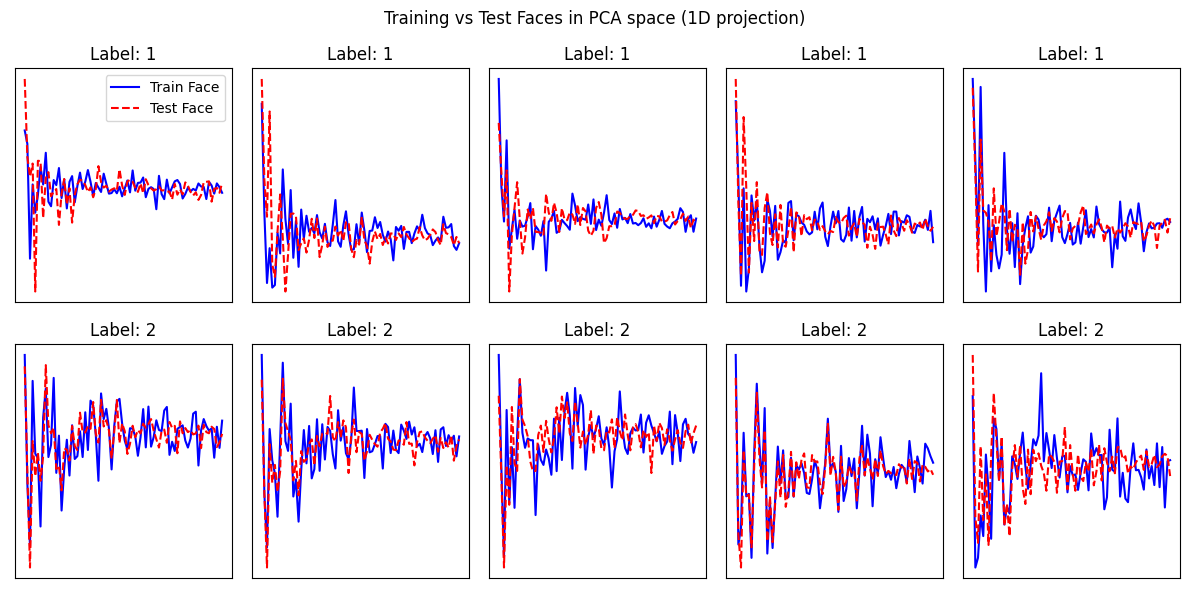

In [23]:
# Visualize few faces: each plot shows the training face and the corresponding test face
def visualize_faces(X_train_pca, X_test_pca, y_labels, n_samples=10):
    plt.figure(figsize=(12, 6))
    for i in range(n_samples):
        ax = plt.subplot(2, n_samples//2, i+1)
        
        train_face = X_train_pca[i]
        test_face = X_test_pca[i]
        
        ax.plot(train_face, label="Train Face", color='blue')
        ax.plot(test_face, label="Test Face", color='red', linestyle='dashed')
        
        ax.set_title(f"Label: {y_labels[i]}")
        plt.xticks([])
        plt.yticks([])
        
        if i == 0:  # فقط نضع الليجند في أول بلوت عشان ميتكررش
            ax.legend()

    plt.suptitle('Training vs Test Faces in PCA space (1D projection)')
    plt.tight_layout()
    plt.show()

# Example: visualize first 10 faces for alpha=0.9
visualize_faces(pca_results[0.9]['train'], pca_results[0.9]['test'], y_train, n_samples=10)


## vesiolization using inverse transforation

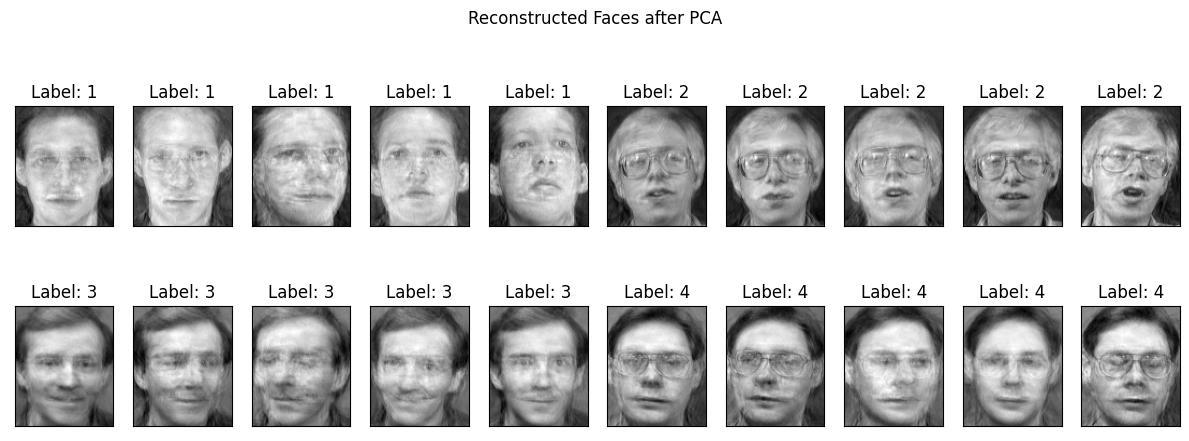

In [13]:
def visualize_reconstructed_faces(pca_obj, X_pca, y_labels, n_samples=10):
    plt.figure(figsize=(12, 5))
    for i in range(n_samples):
        ax = plt.subplot(2, n_samples//2, i+1)
        
        # 1. rebuild a main img (reverse transforme)
        reconstructed_face = np.dot(X_pca[i], pca_obj.components.T) + pca_obj.mean
        
        
        plt.imshow(reconstructed_face.reshape(112, 92), cmap='gray')  # لأن الصور الأصلية 112×92
        ax.set_title(f"Label: {y_labels[i]}")
        plt.xticks([])
        plt.yticks([])
   
    plt.suptitle('Reconstructed Faces after PCA')
    plt.tight_layout()
    plt.show()
visualize_reconstructed_faces(pca_results[0.9]['pca'], pca_results[0.9]['train'], y_train, n_samples=20)



## BOUNS

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [38]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=10304, latent_dim=100):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # Assuming images are normalized
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent


In [39]:
# Convert the data into torch tensors
X_train_tensor = torch.FloatTensor(X_train) / 255.0  # Normalize (important!)
X_test_tensor = torch.FloatTensor(X_test) / 255.0

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



## train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = Autoencoder(input_dim=10304, latent_dim=100).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

n_epochs = 50
autoencoder.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    for batch in train_loader:
        inputs = batch[0].to(device)
        
        optimizer.zero_grad()
        outputs, _ = autoencoder(inputs)
        
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader):.6f}")


Epoch 1/50, Loss: 0.034191
Epoch 2/50, Loss: 0.025535
Epoch 3/50, Loss: 0.024507
Epoch 4/50, Loss: 0.024132
Epoch 5/50, Loss: 0.023305
Epoch 6/50, Loss: 0.023120
Epoch 7/50, Loss: 0.022774
Epoch 8/50, Loss: 0.021347
Epoch 9/50, Loss: 0.019770
Epoch 10/50, Loss: 0.019459
Epoch 11/50, Loss: 0.018713
Epoch 12/50, Loss: 0.018730
Epoch 13/50, Loss: 0.017855
Epoch 14/50, Loss: 0.016946
Epoch 15/50, Loss: 0.016851
Epoch 16/50, Loss: 0.016245
Epoch 17/50, Loss: 0.015450
Epoch 18/50, Loss: 0.015517
Epoch 19/50, Loss: 0.014819
Epoch 20/50, Loss: 0.014571
Epoch 21/50, Loss: 0.014423
Epoch 22/50, Loss: 0.013676
Epoch 23/50, Loss: 0.013229
Epoch 24/50, Loss: 0.012798
Epoch 25/50, Loss: 0.012552
Epoch 26/50, Loss: 0.012172
Epoch 27/50, Loss: 0.011935
Epoch 28/50, Loss: 0.011535
Epoch 29/50, Loss: 0.011437
Epoch 30/50, Loss: 0.011426
Epoch 31/50, Loss: 0.011206
Epoch 32/50, Loss: 0.010855
Epoch 33/50, Loss: 0.010666
Epoch 34/50, Loss: 0.010388
Epoch 35/50, Loss: 0.010205
Epoch 36/50, Loss: 0.010287
E

In [40]:
autoencoder.eval()
with torch.no_grad():
    _, X_train_latent = autoencoder(X_train_tensor.to(device))
    _, X_test_latent = autoencoder(X_test_tensor.to(device))

# Move to CPU and convert to numpy
X_train_latent = X_train_latent.cpu().numpy()
X_test_latent = X_test_latent.cpu().numpy()


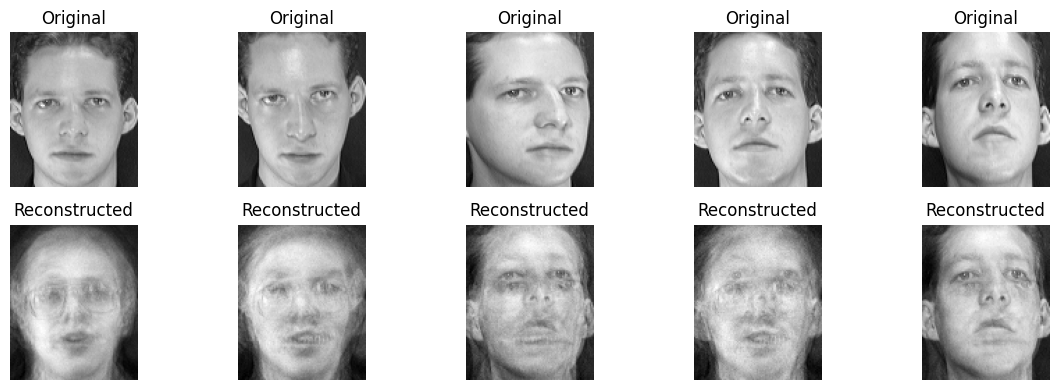

In [41]:
def visualize_reconstruction(autoencoder, X_tensor, n_samples=5):
    autoencoder.eval()
    with torch.no_grad():
        reconstructed, _ = autoencoder(X_tensor[:n_samples].to(device))
        reconstructed = reconstructed.cpu().numpy()
    
    plt.figure(figsize=(12, 4))
    for i in range(n_samples):
        # Original
        ax = plt.subplot(2, n_samples, i+1)
        plt.imshow(X_tensor[i].cpu().numpy().reshape(112,92), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        # Reconstructed
        ax = plt.subplot(2, n_samples, n_samples+i+1)
        plt.imshow(reconstructed[i].reshape(112,92), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
visualize_reconstruction(autoencoder, X_train_tensor, n_samples=5)

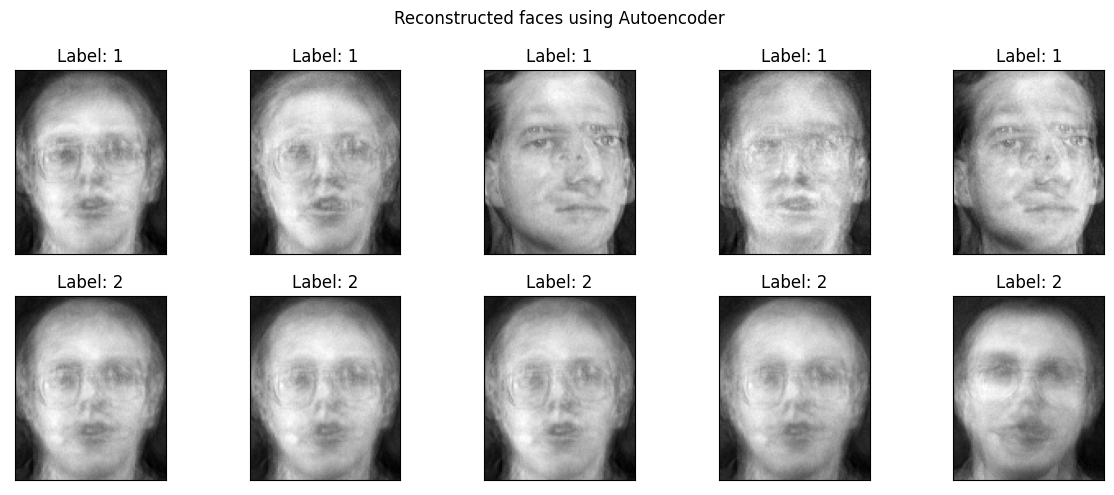

In [ ]:
def visualize_reconstructions(autoencoder, X_tensor, y_labels, n_samples=10):
    autoencoder.eval()
    with torch.no_grad():
        reconstructed, _ = autoencoder(X_tensor[:n_samples].to(device))
        reconstructed = reconstructed.cpu().numpy()
    
    plt.figure(figsize=(12, 5))
    for i in range(n_samples):
        ax = plt.subplot(2, n_samples//2, i+1)
        plt.imshow(reconstructed[i].reshape(112, 92), cmap='gray')
        ax.set_title(f"Label: {y_labels[i]}")
        plt.xticks([])
        plt.yticks([])
    
    plt.suptitle('Reconstructed faces using Autoencoder')
    plt.tight_layout()
    plt.show()

# Example: visualize
visualize_reconstructions(autoencoder, X_train_tensor, y_train, n_samples=10)
